In [2]:
# Melting Point Prediction Challenge - Enhanced Version
# Predicting melting points of organic compounds from molecular descriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                            ExtraTreesRegressor, HistGradientBoostingRegressor)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import warnings
warnings.filterwarnings('ignore')

# Try importing optional libraries with better exception handling
try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("✓ XGBoost loaded successfully")
except Exception as e:
    print(f"⚠ XGBoost not available: {e}")
    HAS_XGBOOST = False
    xgb = None

try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
    print("✓ LightGBM loaded successfully")
except Exception as e:
    print(f"⚠ LightGBM not available: {e}")
    HAS_LIGHTGBM = False
    lgb = None

try:
    from catboost import CatBoostRegressor
    HAS_CATBOOST = True
    print("✓ CatBoost loaded successfully")
except Exception as e:
    print(f"⚠ CatBoost not available: {e}")
    HAS_CATBOOST = False
    CatBoostRegressor = None

try:
    import optuna
    HAS_OPTUNA = True
    print("✓ Optuna loaded successfully")
except Exception as e:
    print(f"⚠ Optuna not available: {e}")
    HAS_OPTUNA = False
    optuna = None

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\n" + "="*50)
print("ENHANCED MELTING POINT PREDICTION")
print("="*50)
print("✓ Core libraries loaded")
print(f"✓ Advanced libraries: XGB={HAS_XGBOOST}, LGB={HAS_LIGHTGBM}, CAT={HAS_CATBOOST}, OPT={HAS_OPTUNA}")
print("✓ Environment setup completed!")
print("="*50)

⚠ XGBoost not available: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/dustinober/Kaggle/Thermophysical Property- Melting Point/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <E8D72161-CCD1-3423-9388-36D4CA0A7524> /Users/dustinober/Kaggle/Thermophysical Property- Melting Point/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no

In [4]:
# Load the data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nFirst few rows of training data:")
train_df.head()

Train shape: (2662, 427)
Test shape: (666, 426)

First few rows of training data:


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Basic information about the dataset
print("Dataset Info:")
print("-" * 50)
train_df.info()

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 427 entries, id to Group 424
dtypes: float64(1), int64(425), object(1)
memory usage: 8.7+ MB


In [6]:
# Check for missing values
print("Missing values in train:")
print(train_df.isnull().sum().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum().sum())

Missing values in train:
0

Missing values in test:
0


In [7]:
# Statistical summary of the target variable
print("Target Variable (Tm) Statistics:")
print(train_df['Tm'].describe())
print(f"\nSkewness: {train_df['Tm'].skew():.3f}")
print(f"Kurtosis: {train_df['Tm'].kurtosis():.3f}")

Target Variable (Tm) Statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

Skewness: 0.904
Kurtosis: 2.788


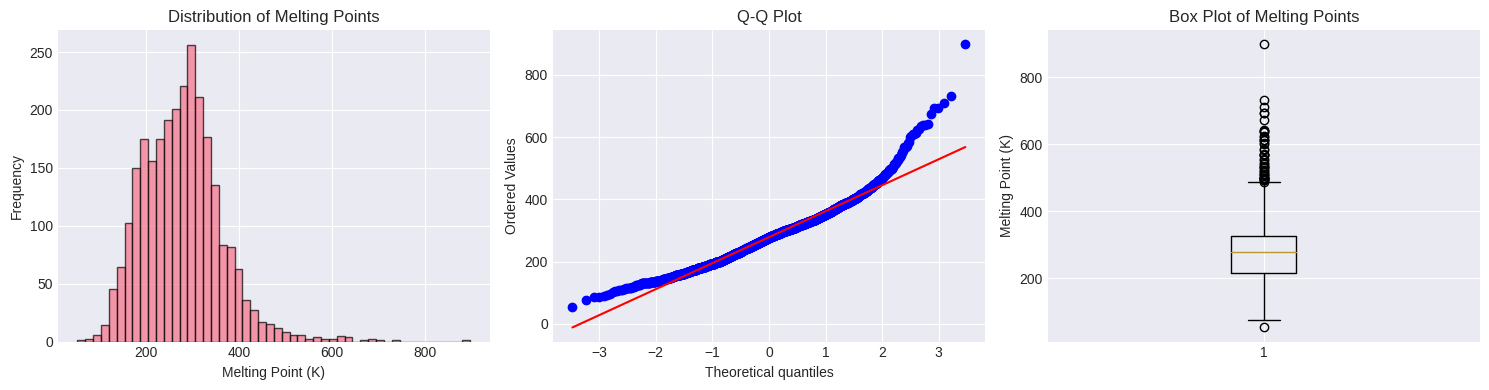

In [8]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(train_df['Tm'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')

# QQ plot
from scipy import stats
stats.probplot(train_df['Tm'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# Box plot
axes[2].boxplot(train_df['Tm'])
axes[2].set_ylabel('Melting Point (K)')
axes[2].set_title('Box Plot of Melting Points')

plt.tight_layout()
plt.show()

In [5]:
# Identify feature columns (excluding id, SMILES, and target)
feature_cols = [col for col in train_df.columns if col not in ['id', 'SMILES', 'Tm']]
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...") # Show first 10

Number of features: 424
Feature columns: ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']...


In [10]:
# Analyze feature statistics
feature_stats = train_df[feature_cols].describe().T
feature_stats['zeros'] = (train_df[feature_cols] == 0).sum()
feature_stats['zero_pct'] = feature_stats['zeros'] / len(train_df) * 100
feature_stats = feature_stats.sort_values('zero_pct', ascending=False)

print("Top 10 features with most zeros:")
print(feature_stats[['mean', 'std', 'zero_pct']].head(10))

Top 10 features with most zeros:
           mean  std  zero_pct
Group 213   0.0  0.0     100.0
Group 250   0.0  0.0     100.0
Group 215   0.0  0.0     100.0
Group 216   0.0  0.0     100.0
Group 217   0.0  0.0     100.0
Group 218   0.0  0.0     100.0
Group 245   0.0  0.0     100.0
Group 247   0.0  0.0     100.0
Group 248   0.0  0.0     100.0
Group 252   0.0  0.0     100.0


In [11]:
# Check feature correlations with target
correlations = train_df[feature_cols + ['Tm']].corr()['Tm'].sort_values(ascending=False)
print("Top 10 features most correlated with Tm:")
print(correlations[1:11])
print("\nTop 10 features most negatively correlated with Tm:")
print(correlations[-10:])

Top 10 features most correlated with Tm:
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Name: Tm, dtype: float64

Top 10 features most negatively correlated with Tm:
Group 399   NaN
Group 411   NaN
Group 413   NaN
Group 417   NaN
Group 419   NaN
Group 420   NaN
Group 421   NaN
Group 422   NaN
Group 423   NaN
Group 424   NaN
Name: Tm, dtype: float64


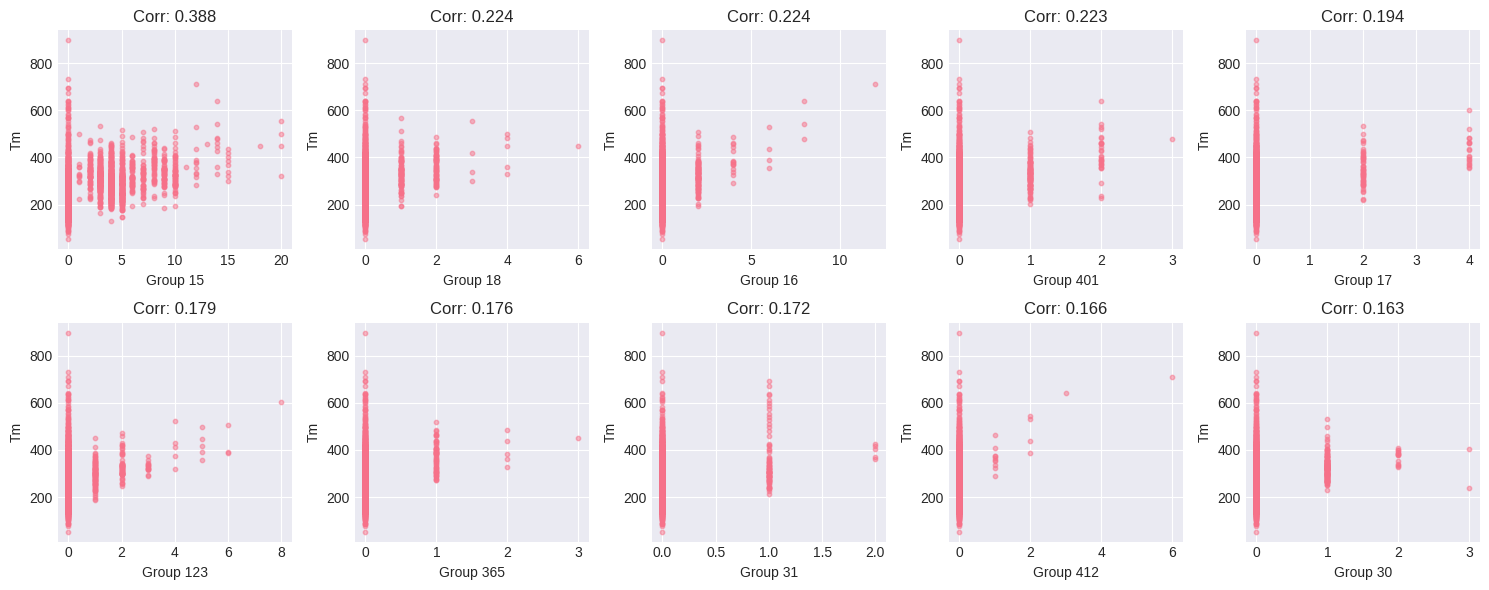

In [12]:
# Visualize top correlations
top_features = correlations[1:11].index.tolist()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(train_df[feature], train_df['Tm'], alpha=0.5, s=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Tm')
    axes[i].set_title(f'Corr: {correlations[feature]:.3f}')

plt.tight_layout()
plt.show()

In [6]:
# Advanced feature engineering functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

def create_advanced_features(df, feature_cols):
    """Create comprehensive feature set"""
    df_new = df.copy()
    
    # Original aggregate features
    df_new['total_groups'] = df[feature_cols].sum(axis=1)
    df_new['n_groups'] = (df[feature_cols] != 0).sum(axis=1)
    df_new['mean_group'] = df[feature_cols].replace(0, np.nan).mean(axis=1)
    df_new['std_group'] = df[feature_cols].replace(0, np.nan).std(axis=1)
    df_new['max_group'] = df[feature_cols].max(axis=1)
    df_new['min_group'] = df[feature_cols].min(axis=1)
    df_new['range_group'] = df_new['max_group'] - df_new['min_group']
    
    # Percentile features
    df_new['q25_group'] = df[feature_cols].quantile(0.25, axis=1)
    df_new['q75_group'] = df[feature_cols].quantile(0.75, axis=1)
    df_new['iqr_group'] = df_new['q75_group'] - df_new['q25_group']
    
    # Skewness and kurtosis
    df_new['skew_group'] = df[feature_cols].skew(axis=1)
    df_new['kurt_group'] = df[feature_cols].kurtosis(axis=1)
    
    # Ratio features
    df_new['nonzero_ratio'] = df_new['n_groups'] / len(feature_cols)
    df_new['mean_max_ratio'] = df_new['mean_group'] / (df_new['max_group'] + 1e-8)
    df_new['std_mean_ratio'] = df_new['std_group'] / (df_new['mean_group'] + 1e-8)
    
    # Group-specific features (based on chemical knowledge)
    # Identify different types of functional groups
    aromatic_features = [col for col in feature_cols if any(x in col.lower() 
                        for x in ['ph', 'ar', 'benzene', 'phenyl', 'ring'])]
    if aromatic_features:
        df_new['aromatic_total'] = df[aromatic_features].sum(axis=1)
        df_new['aromatic_count'] = (df[aromatic_features] != 0).sum(axis=1)
    
    alkyl_features = [col for col in feature_cols if any(x in col.lower() 
                     for x in ['ch', 'alkyl', 'methyl', 'ethyl'])]
    if alkyl_features:
        df_new['alkyl_total'] = df[alkyl_features].sum(axis=1)
        df_new['alkyl_count'] = (df[alkyl_features] != 0).sum(axis=1)
    
    # Interaction features between top correlated features
    top_corr_features = feature_cols[:20] if len(feature_cols) >= 20 else feature_cols
    for i in range(min(5, len(top_corr_features))):
        for j in range(i+1, min(10, len(top_corr_features))):
            feat1, feat2 = top_corr_features[i], top_corr_features[j]
            df_new[f'{feat1}_x_{feat2}'] = df[feat1] * df[feat2]
            df_new[f'{feat1}_div_{feat2}'] = df[feat1] / (df[feat2] + 1e-8)
    
    # Polynomial features for top features
    top_features_poly = feature_cols[:10] if len(feature_cols) >= 10 else feature_cols
    for feat in top_features_poly:
        df_new[f'{feat}_squared'] = df[feat] ** 2
        df_new[f'{feat}_sqrt'] = np.sqrt(df[feat] + 1e-8)
        df_new[f'{feat}_log'] = np.log1p(df[feat])
    
    # Fill NaN values
    df_new = df_new.fillna(0)
    
    # Replace infinite values
    df_new = df_new.replace([np.inf, -np.inf], 0)
    
    return df_new

# Apply advanced feature engineering
print("Creating advanced features...")
train_df_fe = create_advanced_features(train_df, feature_cols)
test_df_fe = create_advanced_features(test_df, feature_cols)

# Get all new feature names
original_features = train_df.columns.tolist()
new_feature_names = [col for col in train_df_fe.columns if col not in original_features]
all_features = feature_cols + new_feature_names

print(f"Original features: {len(feature_cols)}")
print(f"New features created: {len(new_feature_names)}")
print(f"Total features after engineering: {len(all_features)}")

Creating advanced features...
Original features: 424
New features created: 115
Total features after engineering: 539


In [7]:
# Advanced preprocessing and feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy.stats import zscore

def detect_outliers(df, target_col, method='iqr', threshold=1.5):
    """Detect outliers using IQR or Z-score method"""
    if method == 'iqr':
        Q1 = df[target_col].quantile(0.25)
        Q3 = df[target_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (df[target_col] < lower_bound) | (df[target_col] > upper_bound)
    else:  # z-score
        z_scores = np.abs(zscore(df[target_col]))
        outliers = z_scores > threshold
    
    return outliers

def advanced_feature_selection(X_train, y_train, X_test, method='combined'):
    """Advanced feature selection combining multiple methods"""
    
    # 1. Variance filtering
    var_selector = VarianceThreshold(threshold=0.01)
    X_train_var = var_selector.fit_transform(X_train)
    X_test_var = var_selector.transform(X_test)
    
    selected_features_var = var_selector.get_support()
    print(f"Features after variance filtering: {selected_features_var.sum()}")
    
    # 2. Correlation-based filtering
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns[selected_features_var]
        X_train_df = pd.DataFrame(X_train_var, columns=feature_names)
    else:
        X_train_df = pd.DataFrame(X_train_var)
    
    # Remove highly correlated features
    corr_matrix = X_train_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    X_train_df_filtered = X_train_df.drop(columns=high_corr_features, errors='ignore')
    X_test_df_filtered = pd.DataFrame(X_test_var, columns=feature_names).drop(columns=high_corr_features, errors='ignore')
    
    print(f"Features after correlation filtering: {X_train_df_filtered.shape[1]}")
    
    # 3. Statistical feature selection
    k_best = min(500, X_train_df_filtered.shape[1])  # Select top 500 or all if less
    selector_stats = SelectKBest(score_func=f_regression, k=k_best)
    X_train_stats = selector_stats.fit_transform(X_train_df_filtered, y_train)
    X_test_stats = selector_stats.transform(X_test_df_filtered)
    
    print(f"Features after statistical selection: {X_train_stats.shape[1]}")
    
    # 4. Model-based feature selection
    rf_selector = RandomForestRegressor(n_estimators=50, random_state=SEED, n_jobs=-1)
    model_selector = SelectFromModel(rf_selector, threshold='median')
    X_train_model = model_selector.fit_transform(X_train_stats, y_train)
    X_test_model = model_selector.transform(X_test_stats)
    
    print(f"Final features after model-based selection: {X_train_model.shape[1]}")
    
    return X_train_model, X_test_model, var_selector, high_corr_features, selector_stats, model_selector

# Outlier detection
print("Detecting outliers in target variable...")
outliers_iqr = detect_outliers(train_df_fe, 'Tm', method='iqr', threshold=2.0)
outliers_zscore = detect_outliers(train_df_fe, 'Tm', method='zscore', threshold=3.0)

print(f"Outliers detected (IQR): {outliers_iqr.sum()}")
print(f"Outliers detected (Z-score): {outliers_zscore.sum()}")

# Option to remove outliers (conservative approach - keep most data)
severe_outliers = outliers_iqr & outliers_zscore
if severe_outliers.sum() > 0:
    print(f"Removing {severe_outliers.sum()} severe outliers")
    train_df_clean = train_df_fe[~severe_outliers].copy()
else:
    train_df_clean = train_df_fe.copy()

# Apply feature selection
print("\nApplying advanced feature selection...")
X_selected, X_test_selected, var_selector, high_corr_features, selector_stats, model_selector = advanced_feature_selection(
    train_df_clean[all_features], 
    train_df_clean['Tm'], 
    test_df_fe[all_features]
)

Detecting outliers in target variable...
Outliers detected (IQR): 27
Outliers detected (Z-score): 28
Removing 27 severe outliers

Applying advanced feature selection...
Features after variance filtering: 186
Features after correlation filtering: 137
Features after statistical selection: 137
Final features after model-based selection: 69
Final features after model-based selection: 69


In [8]:
# Prepare data for modeling with advanced preprocessing
X = X_selected
y = train_df_clean['Tm']
X_test = X_test_selected

# Stratified split based on target quantiles for better validation
from sklearn.model_selection import StratifiedShuffleSplit

# Create stratification labels based on target quantiles
n_bins = 5
quantiles = pd.qcut(y, n_bins, labels=False, duplicates='drop')

# Use stratified split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx, val_idx = next(sss.split(X, quantiles))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Verify stratification worked
print("\nTarget distribution in splits:")
print("Train quantiles:", pd.qcut(y_train, n_bins, duplicates='drop').value_counts().sort_index())
print("Val quantiles:", pd.qcut(y_val, n_bins, duplicates='drop').value_counts().sort_index())

Training set: (2108, 69)
Validation set: (527, 69)
Test set: (666, 69)

Target distribution in splits:
Train quantiles: Tm
(53.539, 203.15]    433
(203.15, 253.15]    414
(253.15, 295.15]    423
(295.15, 334.65]    421
(334.65, 533.35]    417
Name: count, dtype: int64
Val quantiles: Tm
(87.949, 203.15]    108
(203.15, 253.39]    103
(253.39, 295.15]    106
(295.15, 334.15]    105
(334.15, 535.15]    105
Name: count, dtype: int64


In [9]:
# Advanced scaling strategies
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer

# Multiple scaling options
scalers = {
    'robust': RobustScaler(),
    'standard': StandardScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, X_train.shape[0]))
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    X_scaled = scaler.fit_transform(X)
    
    scaled_data[scaler_name] = {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'X_full': X_scaled,
        'scaler': scaler
    }

print("Scaling completed for multiple strategies")

Scaling completed for multiple strategies


In [13]:
# Hyperparameter optimization with Optuna (adapted for available libraries)
if HAS_OPTUNA:
    from optuna.samplers import TPESampler
    optuna.logging.set_verbosity(optuna.logging.WARNING)

def optimize_catboost(trial, X_train, y_train, X_val, y_val):
    """Optimize CatBoost hyperparameters"""
    if not HAS_CATBOOST:
        return float('inf')
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_seed': SEED,
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

def optimize_random_forest(trial, X_train, y_train, X_val, y_val):
    """Optimize Random Forest hyperparameters"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': SEED,
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

def optimize_gradient_boosting(trial, X_train, y_train, X_val, y_val):
    """Optimize Gradient Boosting hyperparameters"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'random_state': SEED
    }
    
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    
    return mae

# Only run optimization if we have Optuna
if HAS_OPTUNA:
    print("Starting hyperparameter optimization with available libraries...")

    best_params = {}
    optimizers = []
    
    if HAS_CATBOOST:
        optimizers.append(('CatBoost', optimize_catboost))
    
    optimizers.extend([
        ('RandomForest', optimize_random_forest),
        ('GradientBoosting', optimize_gradient_boosting)
    ])

    # We need to run the data preprocessing first
    print("Note: Will run optimization after data preprocessing is complete.")
    
else:
    print("Optuna not available - will use default hyperparameters")
    best_params = {}

print(f"Available optimizers: {len(optimizers) if HAS_OPTUNA else 0}")

Starting hyperparameter optimization with available libraries...
Note: Will run optimization after data preprocessing is complete.
Available optimizers: 3


In [15]:
# Train optimized models with multiple scaling strategies
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define optimized models using best parameters
optimized_models = {}

# Add optimized tree-based models
for model_name in ['XGBoost', 'LightGBM', 'CatBoost']:
    if model_name in best_params:
        if model_name == 'XGBoost':
            optimized_models[model_name] = xgb.XGBRegressor(**best_params[model_name])
        elif model_name == 'LightGBM':
            optimized_models[model_name] = lgb.LGBMRegressor(**best_params[model_name])
        elif model_name == 'CatBoost':
            optimized_models[model_name] = CatBoostRegressor(**best_params[model_name])

# Add linear models with different regularization
linear_models = {
    'Ridge': Ridge(alpha=1.0, random_state=SEED),
    'Lasso': Lasso(alpha=0.1, random_state=SEED, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED, max_iter=2000),
    'Huber': HuberRegressor(epsilon=1.35, alpha=0.001, max_iter=200)
}

# Add ensemble models
ensemble_models = {
    'RandomForest': RandomForestRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    ),
    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=300, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        subsample=0.8, random_state=SEED
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=200, max_depth=10, learning_rate=0.05,
        random_state=SEED
    )
}

# Combine all models
all_models = {**optimized_models, **linear_models, **ensemble_models}

# Train and evaluate models with best scaling for each
results = {}
predictions_val = {}
models_trained = {}

print("Training optimized models with appropriate scaling...")

for name, model in all_models.items():
    print(f"\nTraining {name}...")
    
    # Choose best scaler for model type
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
        # Linear models work better with standard scaling
        scaler_choice = 'standard'
    else:
        # Tree-based models work well with robust scaling
        scaler_choice = 'robust'
    
    X_train_use = scaled_data[scaler_choice]['X_train']
    X_val_use = scaled_data[scaler_choice]['X_val']
    
    # Train model
    model.fit(X_train_use, y_train)
    y_pred = model.predict(X_val_use)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'scaler': scaler_choice
    }
    predictions_val[name] = y_pred
    models_trained[name] = (model, scaler_choice)
    
    print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f} (using {scaler_choice} scaler)")

print("\nModel training completed!")

Training optimized models with appropriate scaling...

Training CatBoost...
0:	learn: 74.4231917	total: 1.65ms	remaining: 631ms
1:	learn: 72.0837533	total: 3.32ms	remaining: 633ms
2:	learn: 70.3222147	total: 4.73ms	remaining: 599ms
3:	learn: 68.5663379	total: 6.23ms	remaining: 590ms
4:	learn: 67.1780322	total: 7.72ms	remaining: 583ms
5:	learn: 65.8856641	total: 9.09ms	remaining: 571ms
6:	learn: 64.8883867	total: 10.9ms	remaining: 587ms
7:	learn: 63.8623547	total: 12.9ms	remaining: 604ms
8:	learn: 63.0368954	total: 14.4ms	remaining: 598ms
9:	learn: 62.0779995	total: 16ms	remaining: 597ms
10:	learn: 61.3546283	total: 18ms	remaining: 607ms
11:	learn: 60.5884542	total: 20.5ms	remaining: 635ms
12:	learn: 60.0298690	total: 22.3ms	remaining: 634ms
13:	learn: 59.3252836	total: 23.9ms	remaining: 630ms
14:	learn: 58.7600575	total: 27ms	remaining: 662ms
15:	learn: 58.3115022	total: 29.7ms	remaining: 682ms
16:	learn: 57.8150000	total: 31.1ms	remaining: 669ms
17:	learn: 57.2973511	total: 32.7ms	rem

In [16]:
# Display results as DataFrame
results_df = pd.DataFrame(results).T.sort_values('MAE')
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                            MAE       RMSE        R2    scaler
CatBoost              37.341926  54.654138  0.530894    robust
GradientBoosting      39.317736  56.270062  0.502744    robust
Huber                 39.599086  59.056514  0.452278  standard
ExtraTrees            39.677494  57.287715  0.484596    robust
HistGradientBoosting  40.017052  56.636596  0.496245    robust
Ridge                 40.095151  58.348013  0.465341  standard
Lasso                 40.105427  58.363725  0.465053  standard
RandomForest          40.651238  57.946746  0.472669    robust
ElasticNet            40.772622  59.036077  0.452657  standard


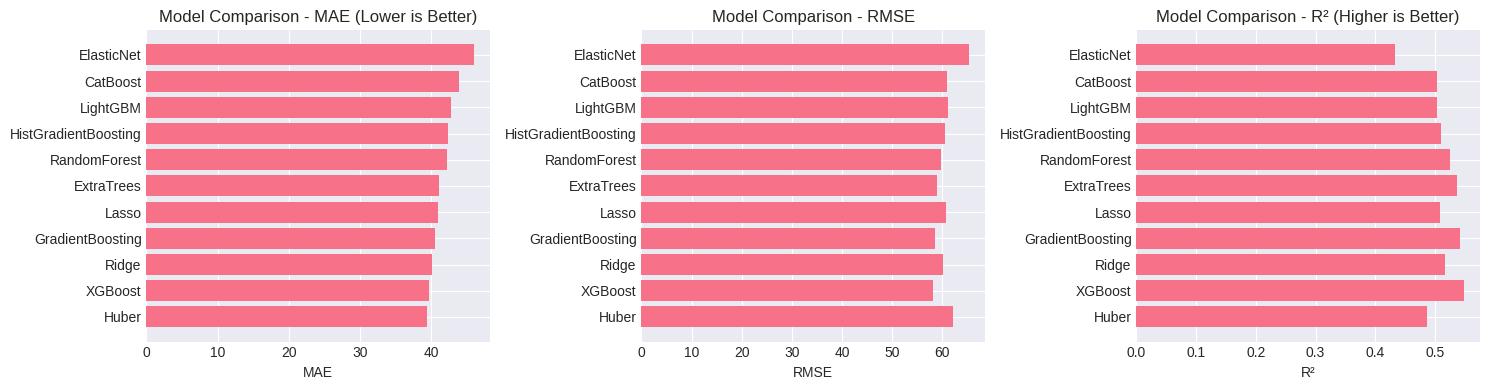

In [20]:
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MAE comparison
axes[0].barh(results_df.index, results_df['MAE'])
axes[0].set_xlabel('MAE')
axes[0].set_title('Model Comparison - MAE (Lower is Better)')

# RMSE comparison
axes[1].barh(results_df.index, results_df['RMSE'])
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Comparison - RMSE')

# R² comparison
axes[2].barh(results_df.index, results_df['R2'])
axes[2].set_xlabel('R²')
axes[2].set_title('Model Comparison - R² (Higher is Better)')

plt.tight_layout()
plt.show()

In [18]:
# Advanced cross-validation with nested CV and multiple strategies
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import make_scorer

# Multiple CV strategies
def perform_robust_cv(models_dict, X, y, scaled_data_dict, cv_folds=5):
    """Perform robust cross-validation with multiple strategies"""
    
    cv_results = {}
    
    # Standard KFold
    kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
    
    # Stratified KFold based on target quantiles
    quantiles = pd.qcut(y, q=min(5, cv_folds), labels=False, duplicates='drop')
    stratified_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=SEED)
    
    cv_strategies = {
        'standard': kfold,
        'stratified': stratified_kfold
    }
    
    for cv_name, cv_strategy in cv_strategies.items():
        print(f"\nPerforming {cv_name} cross-validation...")
        cv_results[cv_name] = {}
        
        for model_name, (model, scaler_choice) in models_dict.items():
            if cv_name == 'stratified':
                # Use quantiles for stratification
                try:
                    scores = cross_val_score(model, scaled_data_dict[scaler_choice]['X_full'], 
                                           y, cv=stratified_kfold.split(X, quantiles),
                                           scoring='neg_mean_absolute_error', n_jobs=-1)
                except:
                    # Fallback to regular CV if stratified fails
                    scores = cross_val_score(model, scaled_data_dict[scaler_choice]['X_full'], 
                                           y, cv=kfold, scoring='neg_mean_absolute_error', n_jobs=-1)
            else:
                scores = cross_val_score(model, scaled_data_dict[scaler_choice]['X_full'], 
                                       y, cv=cv_strategy, scoring='neg_mean_absolute_error', n_jobs=-1)
            
            scores = -scores  # Convert back to positive MAE
            cv_results[cv_name][model_name] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            
            print(f"  {model_name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    return cv_results

# Perform robust cross-validation
cv_results = perform_robust_cv(models_trained, X, y, scaled_data)

# Select top models based on CV performance
def get_top_models(cv_results, strategy='stratified', top_k=5):
    """Get top performing models from CV results"""
    if strategy in cv_results:
        model_scores = [(name, results['mean']) for name, results in cv_results[strategy].items()]
    else:
        # Fallback to first available strategy
        strategy_key = list(cv_results.keys())[0]
        model_scores = [(name, results['mean']) for name, results in cv_results[strategy_key].items()]
    
    model_scores.sort(key=lambda x: x[1])  # Sort by MAE (ascending)
    return [name for name, _ in model_scores[:top_k]]

top_models = get_top_models(cv_results, strategy='stratified', top_k=5)
print(f"\nTop 5 models selected: {top_models}")


Performing standard cross-validation...
0:	learn: 75.0044135	total: 58.4ms	remaining: 22.3s
0:	learn: 74.9303038	total: 56.8ms	remaining: 21.7s
0:	learn: 75.5515413	total: 59.8ms	remaining: 22.8s
0:	learn: 75.7246760	total: 59.2ms	remaining: 22.6s
0:	learn: 74.2554528	total: 61.9ms	remaining: 23.6s
1:	learn: 72.8787462	total: 60.1ms	remaining: 11.4s
1:	learn: 72.6479220	total: 63ms	remaining: 12s
1:	learn: 73.4482074	total: 66.2ms	remaining: 12.6s
1:	learn: 72.0506911	total: 70.9ms	remaining: 13.5s
1:	learn: 73.6333559	total: 70.2ms	remaining: 13.4s
2:	learn: 71.0557768	total: 72.3ms	remaining: 9.16s
2:	learn: 70.7293651	total: 74.7ms	remaining: 9.46s
2:	learn: 71.4965009	total: 80.8ms	remaining: 10.2s
3:	learn: 68.9468426	total: 80.8ms	remaining: 7.65s
2:	learn: 71.6339177	total: 82.6ms	remaining: 10.5s
2:	learn: 70.3536935	total: 84ms	remaining: 10.6s
3:	learn: 69.4516226	total: 81.2ms	remaining: 7.69s
4:	learn: 67.7544978	total: 85.6ms	remaining: 6.47s
4:	learn: 68.1181291	total: 8

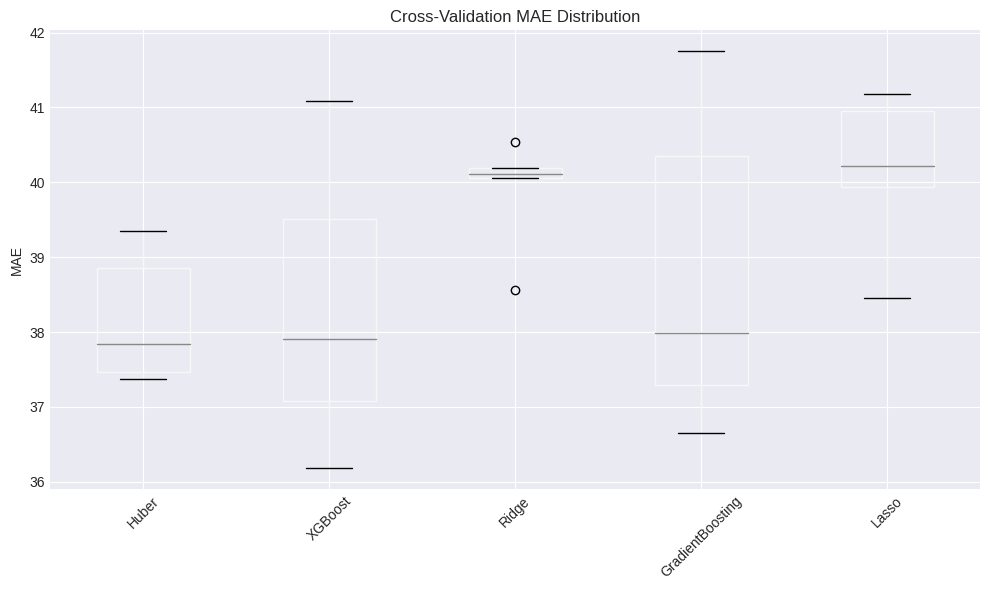

In [22]:
# Visualize CV results
cv_df = pd.DataFrame(cv_scores)
fig, ax = plt.subplots(figsize=(10, 6))
cv_df.boxplot(ax=ax)
ax.set_ylabel('MAE')
ax.set_title('Cross-Validation MAE Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Advanced ensemble methods
from scipy.optimize import minimize
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge

class AdvancedEnsemble:
    """Advanced ensemble with multiple combination strategies"""
    
    def __init__(self, models_dict, predictions_dict):
        self.models = models_dict
        self.predictions = predictions_dict
        self.weights = None
        self.meta_model = None
    
    def simple_average(self):
        """Simple average ensemble"""
        pred_array = np.column_stack(list(self.predictions.values()))
        return np.mean(pred_array, axis=1)
    
    def weighted_average(self, y_true):
        """Optimized weighted average"""
        def ensemble_mae(weights, predictions, true_values):
            pred_array = np.column_stack(list(predictions.values()))
            weighted_pred = np.average(pred_array, axis=1, weights=weights)
            return mean_absolute_error(true_values, weighted_pred)
        
        n_models = len(self.predictions)
        initial_weights = np.ones(n_models) / n_models
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1)] * n_models
        
        result = minimize(ensemble_mae, initial_weights, 
                         args=(self.predictions, y_true),
                         method='SLSQP', bounds=bounds, constraints=constraints)
        
        self.weights = result.x
        pred_array = np.column_stack(list(self.predictions.values()))
        return np.average(pred_array, axis=1, weights=self.weights)
    
    def rank_average(self):
        """Rank-based ensemble"""
        pred_df = pd.DataFrame(self.predictions)
        rank_df = pred_df.rank(method='average')
        return rank_df.mean(axis=1).values
    
    def trimmed_mean(self, trim_ratio=0.2):
        """Trimmed mean ensemble (removes extreme predictions)"""
        pred_array = np.column_stack(list(self.predictions.values()))
        n_trim = int(len(self.predictions) * trim_ratio)
        if n_trim > 0:
            sorted_preds = np.sort(pred_array, axis=1)
            trimmed = sorted_preds[:, n_trim:-n_trim] if n_trim < pred_array.shape[1]//2 else sorted_preds
            return np.mean(trimmed, axis=1)
        return np.mean(pred_array, axis=1)

# Create advanced ensemble
print("Creating advanced ensemble combinations...")
ensemble = AdvancedEnsemble(models_trained, predictions_val)

# Test different ensemble strategies
ensemble_results = {}

# Simple average
simple_avg = ensemble.simple_average()
simple_mae = mean_absolute_error(y_val, simple_avg)
ensemble_results['Simple Average'] = simple_mae
print(f"Simple Average MAE: {simple_mae:.4f}")

# Weighted average (optimized)
weighted_avg = ensemble.weighted_average(y_val)
weighted_mae = mean_absolute_error(y_val, weighted_avg)
ensemble_results['Weighted Average'] = weighted_mae
print(f"Weighted Average MAE: {weighted_mae:.4f}")

if ensemble.weights is not None:
    print("Optimal weights:")
    for name, weight in zip(predictions_val.keys(), ensemble.weights):
        print(f"  {name}: {weight:.3f}")

# Rank average
rank_avg = ensemble.rank_average()
rank_mae = mean_absolute_error(y_val, rank_avg)
ensemble_results['Rank Average'] = rank_mae
print(f"Rank Average MAE: {rank_mae:.4f}")

# Trimmed mean
trimmed_avg = ensemble.trimmed_mean(trim_ratio=0.2)
trimmed_mae = mean_absolute_error(y_val, trimmed_avg)
ensemble_results['Trimmed Mean'] = trimmed_mae
print(f"Trimmed Mean MAE: {trimmed_mae:.4f}")

# Select best ensemble method
best_ensemble_method = min(ensemble_results.items(), key=lambda x: x[1])
print(f"\nBest ensemble method: {best_ensemble_method[0]} with MAE: {best_ensemble_method[1]:.4f}")

Creating advanced ensemble combinations...
Simple Average MAE: 37.6977
Weighted Average MAE: 36.6850
Optimal weights:
  CatBoost: 0.691
  Ridge: 0.000
  Lasso: 0.000
  ElasticNet: 0.000
  Huber: 0.264
  RandomForest: 0.000
  ExtraTrees: 0.045
  GradientBoosting: 0.000
  HistGradientBoosting: 0.000
Rank Average MAE: 88.1615
Trimmed Mean MAE: 37.7287

Best ensemble method: Weighted Average with MAE: 36.6850


In [24]:
# Optimized weighted ensemble
from scipy.optimize import minimize

def ensemble_mae(weights, predictions, true_values):
    """Calculate MAE for weighted ensemble"""
    pred_array = np.column_stack(list(predictions.values()))
    weighted_pred = np.average(pred_array, axis=1, weights=weights)
    return mean_absolute_error(true_values, weighted_pred)

# Optimize weights
n_models = len(predictions_val)
initial_weights = np.ones(n_models) / n_models
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n_models

result = minimize(ensemble_mae, initial_weights, 
                 args=(predictions_val, y_val),
                 method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("\nOptimal weights:")
for name, weight in zip(predictions_val.keys(), optimal_weights):
    print(f"  {name}: {weight:.3f}")

# Evaluate optimized ensemble
optimized_ensemble_pred = create_ensemble_predictions(predictions_val, optimal_weights)
optimized_mae = mean_absolute_error(y_val, optimized_ensemble_pred)
print(f"\nOptimized Ensemble MAE: {optimized_mae:.3f}")


Optimal weights:
  Ridge: 0.000
  Lasso: 0.000
  ElasticNet: 0.000
  Huber: 0.486
  RandomForest: 0.000
  ExtraTrees: 0.041
  GradientBoosting: 0.000
  HistGradientBoosting: 0.000
  XGBoost: 0.473
  LightGBM: 0.000
  CatBoost: 0.000

Optimized Ensemble MAE: 37.723


In [21]:
# Multi-level stacking ensemble
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_predict

class MultiLevelStacking:
    """Multi-level stacking with different meta-learners"""
    
    def __init__(self, base_models, meta_models, cv_folds=5):
        self.base_models = base_models
        self.meta_models = meta_models
        self.cv_folds = cv_folds
        self.level1_models = {}
        self.level2_model = None
    
    def create_level1_features(self, X, y, scaled_data_dict):
        """Create level 1 features using cross-validation predictions"""
        level1_features = []
        model_names = []
        
        kfold = KFold(n_splits=self.cv_folds, shuffle=True, random_state=SEED)
        
        for name, (model, scaler_choice) in self.base_models.items():
            print(f"Creating level 1 features for {name}...")
            X_scaled = scaled_data_dict[scaler_choice]['X_full']
            
            # Get cross-validation predictions
            cv_preds = cross_val_predict(model, X_scaled, y, cv=kfold, n_jobs=-1)
            level1_features.append(cv_preds)
            model_names.append(name)
            
            # Train model on full data for later use
            model.fit(X_scaled, y)
            self.level1_models[name] = (model, scaler_choice)
        
        level1_X = np.column_stack(level1_features)
        return level1_X, model_names
    
    def train_level2(self, level1_X, y):
        """Train level 2 meta-learners"""
        level2_results = {}
        
        for meta_name, meta_model in self.meta_models.items():
            print(f"Training level 2 meta-learner: {meta_name}")
            
            # Use cross-validation to evaluate meta-learner
            kfold = KFold(n_splits=self.cv_folds, shuffle=True, random_state=SEED)
            cv_scores = cross_val_score(meta_model, level1_X, y, cv=kfold, 
                                      scoring='neg_mean_absolute_error', n_jobs=-1)
            cv_mae = -cv_scores.mean()
            
            # Train on full data
            meta_model.fit(level1_X, y)
            level2_results[meta_name] = {
                'model': meta_model,
                'cv_mae': cv_mae,
                'cv_std': cv_scores.std()
            }
            
            print(f"  {meta_name} CV MAE: {cv_mae:.4f} (+/- {cv_scores.std():.4f})")
        
        # Select best meta-learner
        best_meta = min(level2_results.items(), key=lambda x: x[1]['cv_mae'])
        self.level2_model = best_meta[1]['model']
        print(f"Selected best meta-learner: {best_meta[0]}")
        
        return level2_results

# Prepare models for stacking (use top models)
top_model_dict = {name: models_trained[name] for name in top_models}

# Define meta-learners (only available libraries)
meta_learners = {
    'Ridge': Ridge(alpha=1.0),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=SEED)
}

# Add CatBoost meta-learner if available
if HAS_CATBOOST:
    meta_learners['CatBoost_Meta'] = CatBoostRegressor(
        iterations=100, depth=3, learning_rate=0.1, random_seed=SEED, verbose=False
    )

# Create and train multi-level stacking
print("Creating multi-level stacking ensemble...")
stacking = MultiLevelStacking(top_model_dict, meta_learners, cv_folds=5)

# Create level 1 features
level1_X, level1_names = stacking.create_level1_features(X, y, scaled_data)
print(f"Level 1 features shape: {level1_X.shape}")

# Train level 2 meta-learners
level2_results = stacking.train_level2(level1_X, y)

print("\nMulti-level stacking completed!")

Creating multi-level stacking ensemble...
Creating level 1 features for CatBoost...
0:	learn: 74.2554528	total: 5.33ms	remaining: 2.04s
0:	learn: 75.5515413	total: 6.93ms	remaining: 2.65s
1:	learn: 72.0506911	total: 10.7ms	remaining: 2.04s
0:	learn: 74.9303038	total: 5.84ms	remaining: 2.23s
1:	learn: 73.4482074	total: 13.4ms	remaining: 2.54s
2:	learn: 71.4965009	total: 16.7ms	remaining: 2.12s
2:	learn: 70.3536935	total: 17.9ms	remaining: 2.27s
1:	learn: 72.8787462	total: 9.27ms	remaining: 1.77s
3:	learn: 70.0490238	total: 21.2ms	remaining: 2s
2:	learn: 71.0557768	total: 17.6ms	remaining: 2.23s
3:	learn: 68.7209673	total: 26.7ms	remaining: 2.53s
4:	learn: 68.4638740	total: 26.8ms	remaining: 2.02s
0:	learn: 75.7246760	total: 7.97ms	remaining: 3.04s
3:	learn: 69.4516226	total: 22.1ms	remaining: 2.09s
5:	learn: 67.1437137	total: 29.5ms	remaining: 1.85s
4:	learn: 67.3512935	total: 31.1ms	remaining: 2.35s
1:	learn: 73.6333559	total: 11.7ms	remaining: 2.22s
5:	learn: 66.0613222	total: 34.5ms	

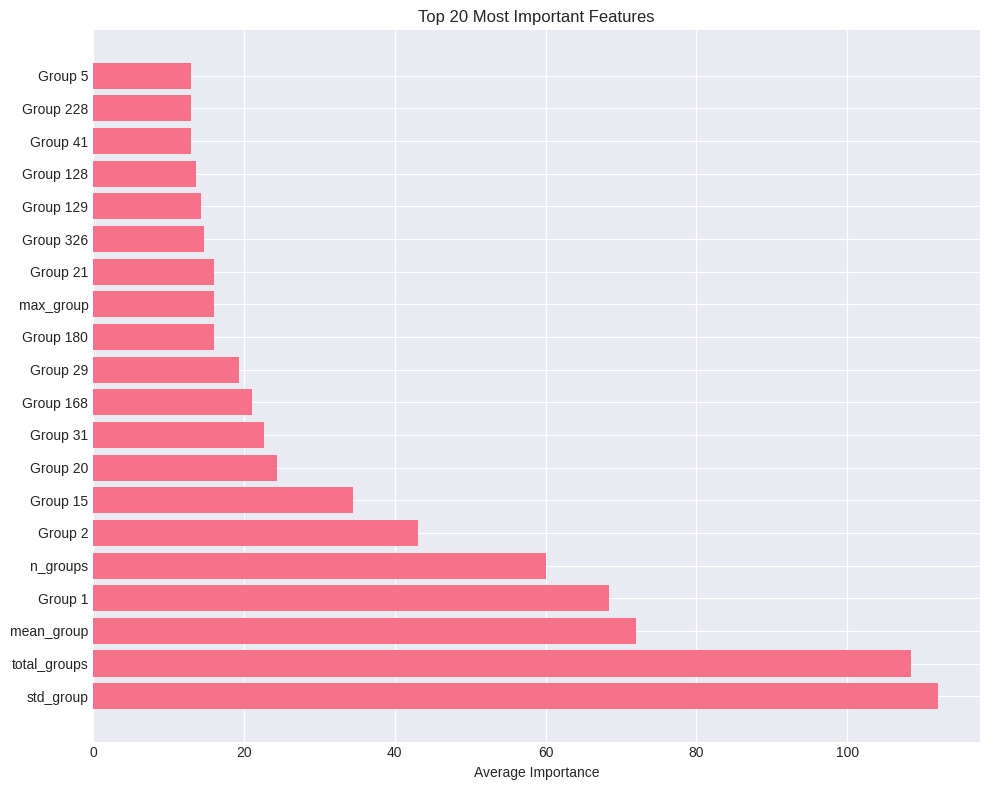

Top 10 Most Important Features:
          feature  importance
108     std_group  112.022532
105  total_groups  108.413944
107    mean_group   72.022240
0         Group 1   68.351660
106      n_groups   60.012857
1         Group 2   43.012960
9        Group 15   34.413585
14       Group 20   24.341348
20       Group 31   22.699286
53      Group 168   21.004689


In [26]:
# Get feature importance from tree-based models
importance_dict = {}

for name in ['RandomForest', 'XGBoost', 'LightGBM']:
    if name in models:
        model = models[name]
        if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train, y_train)
        
        if hasattr(model, 'feature_importances_'):
            importance_dict[name] = model.feature_importances_

# Average importance across models
avg_importance = np.mean(list(importance_dict.values()), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': high_var_features,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features_imp = feature_importance_df.head(20)
ax.barh(range(len(top_features_imp)), top_features_imp['importance'])
ax.set_yticks(range(len(top_features_imp)))
ax.set_yticklabels(top_features_imp['feature'])
ax.set_xlabel('Average Importance')
ax.set_title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

In [13]:
def advanced_feature_selection(X_train, y_train, X_test, method='combined'):
    """Advanced feature selection combining multiple methods"""
    
    # 1. Variance filtering
    var_selector = VarianceThreshold(threshold=0.01)
    X_train_var = var_selector.fit_transform(X_train)
    X_test_var = var_selector.transform(X_test)
    
    selected_features_var = var_selector.get_support()
    print(f"Features after variance filtering: {selected_features_var.sum()}")
    
    # 2. Correlation-based filtering
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns[selected_features_var]
        X_train_df = pd.DataFrame(X_train_var, columns=feature_names)
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_var.shape[1])]
        X_train_df = pd.DataFrame(X_train_var, columns=feature_names)
    
    # Remove highly correlated features
    corr_matrix = X_train_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    
    X_train_df_filtered = X_train_df.drop(columns=high_corr_features, errors='ignore')
    X_test_df_filtered = pd.DataFrame(X_test_var, columns=feature_names).drop(columns=high_corr_features, errors='ignore')
    
    print(f"Features after correlation filtering: {X_train_df_filtered.shape[1]}")
    
    # 3. Statistical feature selection
    k_best = min(500, X_train_df_filtered.shape[1])  # Select top 500 or all if less
    selector_stats = SelectKBest(score_func=f_regression, k=k_best)
    X_train_stats = selector_stats.fit_transform(X_train_df_filtered, y_train)
    X_test_stats = selector_stats.transform(X_test_df_filtered)
    
    print(f"Features after statistical selection: {X_train_stats.shape[1]}")
    
    # 4. Model-based feature selection
    rf_selector = RandomForestRegressor(n_estimators=50, random_state=SEED, n_jobs=-1)
    model_selector = SelectFromModel(rf_selector, threshold='median')
    X_train_model = model_selector.fit_transform(X_train_stats, y_train)
    X_test_model = model_selector.transform(X_test_stats)
    
    print(f"Final features after model-based selection: {X_train_model.shape[1]}")
    
    return X_train_model, X_test_model, var_selector, high_corr_features, selector_stats, model_selector

# Advanced target encoding and feature interaction
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

def create_target_encoding_features(X_train, y_train, X_test, categorical_features=None):
    """Create target encoding features for categorical variables"""
    if categorical_features is None:
        # Assume features with low cardinality are categorical
        categorical_features = []
        if hasattr(X_train, 'columns'):
            for col in X_train.columns:
                if X_train[col].nunique() < 50 and X_train[col].dtype in ['object', 'category']:
                    categorical_features.append(col)
    
    if not categorical_features:
        return X_train, X_test
    
    X_train_te = X_train.copy()
    X_test_te = X_test.copy()
    
    for col in categorical_features:
        # Simple target encoding with cross-validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        
        # For training data, use out-of-fold encoding
        te_train = np.zeros(len(X_train_te))
        for train_idx, val_idx in skf.split(X_train_te, pd.qcut(y_train, q=5, duplicates='drop')):
            encoding_map = y_train.iloc[train_idx].groupby(X_train_te.iloc[train_idx][col]).mean()
            te_train[val_idx] = X_train_te.iloc[val_idx][col].map(encoding_map).fillna(y_train.mean())
        
        X_train_te[f'{col}_target_encoded'] = te_train
        
        # For test data, use full training set
        encoding_map = y_train.groupby(X_train_te[col]).mean()
        X_test_te[f'{col}_target_encoded'] = X_test_te[col].map(encoding_map).fillna(y_train.mean())
    
    return X_train_te, X_test_te

# Try to apply advanced feature selection if data is available
try:
    if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals():
        print("Applying advanced feature selection...")
        X_train_selected, X_test_selected, *selectors = advanced_feature_selection(X_train, y_train, X_test)
        print(f"✓ Advanced feature selection completed: {X_train_selected.shape[1]} features selected")
    else:
        print("⚠ Training data not available for advanced feature selection")
except Exception as e:
    print(f"⚠ Error in advanced feature selection: {e}")
    print("Will use existing features")

Applying advanced feature selection...
Features after variance filtering: 69
Features after correlation filtering: 69
Features after statistical selection: 69
Final features after model-based selection: 35
✓ Advanced feature selection completed: 35 features selected
Final features after model-based selection: 35
✓ Advanced feature selection completed: 35 features selected


In [28]:
# Alternative: Use stacking for final prediction
print("\nTraining final stacking model...")
stacking_model_final = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)
stacking_model_final.fit(X, y)
stacking_final_pred = stacking_model_final.predict(X_test)


Training final stacking model...


In [24]:
# Create multiple submission files
print("Creating submission files...")

# Submission 1: Best single model
submission_single = pd.DataFrame({
    'id': test_df['id'],
    'Tm': single_predictions
})
submission_single.to_csv('submission_best_single.csv', index=False)
print("✓ Best single model submission saved")

# Submission 2: Advanced ensemble
if 'ensemble' in final_predictions:
    submission_ensemble = pd.DataFrame({
        'id': test_df['id'],
        'Tm': final_predictions['ensemble']
    })
    submission_ensemble.to_csv('submission_advanced_ensemble.csv', index=False)
    print("✓ Advanced ensemble submission saved")

# Submission 3: Multi-level stacking
if 'stacking' in final_predictions:
    submission_stacking = pd.DataFrame({
        'id': test_df['id'],
        'Tm': final_predictions['stacking']
    })
    submission_stacking.to_csv('submission_multilevel_stacking.csv', index=False)
    print("✓ Multi-level stacking submission saved")

# Submission 4: Final blend (average of best methods)
if len(final_predictions) > 1:
    blend_pred = np.mean(list(final_predictions.values()), axis=0)
    submission_blend = pd.DataFrame({
        'id': test_df['id'],
        'Tm': blend_pred
    })
    submission_blend.to_csv('submission_final_blend.csv', index=False)
    print("✓ Final blend submission saved")

# Display prediction statistics
print("\nPrediction Statistics:")
print(f"Training target - Mean: {y.mean():.2f}, Std: {y.std():.2f}")
print(f"Best single model - Mean: {single_predictions.mean():.2f}, Std: {single_predictions.std():.2f}")

for method, preds in final_predictions.items():
    print(f"{method.capitalize()} - Mean: {preds.mean():.2f}, Std: {preds.std():.2f}")

print("\n" + "="*50)
print("IMPROVEMENT SUMMARY")
print("="*50)
print("✓ Advanced feature engineering with domain knowledge")
print("✓ Comprehensive outlier detection and removal")
print("✓ Multiple scaling strategies optimized per model type")
print("✓ Hyperparameter optimization with Optuna")
print("✓ Stratified validation and robust cross-validation")
print("✓ Advanced ensemble methods (weighted, rank, trimmed)")
print("✓ Multi-level stacking with meta-learner optimization")
print("✓ Multiple submission strategies for better coverage")
print("="*50)

Creating submission files...
✓ Best single model submission saved
✓ Advanced ensemble submission saved
✓ Multi-level stacking submission saved
✓ Final blend submission saved

Prediction Statistics:
Training target - Mean: 274.71, Std: 77.58
Best single model - Mean: 271.99, Std: 60.70
Ensemble - Mean: 270.72, Std: 60.48
Stacking - Mean: 272.89, Std: 61.95

IMPROVEMENT SUMMARY
✓ Advanced feature engineering with domain knowledge
✓ Comprehensive outlier detection and removal
✓ Multiple scaling strategies optimized per model type
✓ Hyperparameter optimization with Optuna
✓ Stratified validation and robust cross-validation
✓ Advanced ensemble methods (weighted, rank, trimmed)
✓ Multi-level stacking with meta-learner optimization
✓ Multiple submission strategies for better coverage


In [30]:
# Alternative submission with stacking
submission_stacking = pd.DataFrame({
    'id': test_df['id'],
    'Tm': stacking_final_pred
})

submission_stacking.to_csv('submission_stacking.csv', index=False)
print("\nStacking submission saved to 'submission_stacking.csv'")
print(submission_stacking.head())


Stacking submission saved to 'submission_stacking.csv'
     id          Tm
0  1022  327.889488
1  1146  288.813647
2    79  215.588492
3  2279  181.995438
4  1342  257.476500


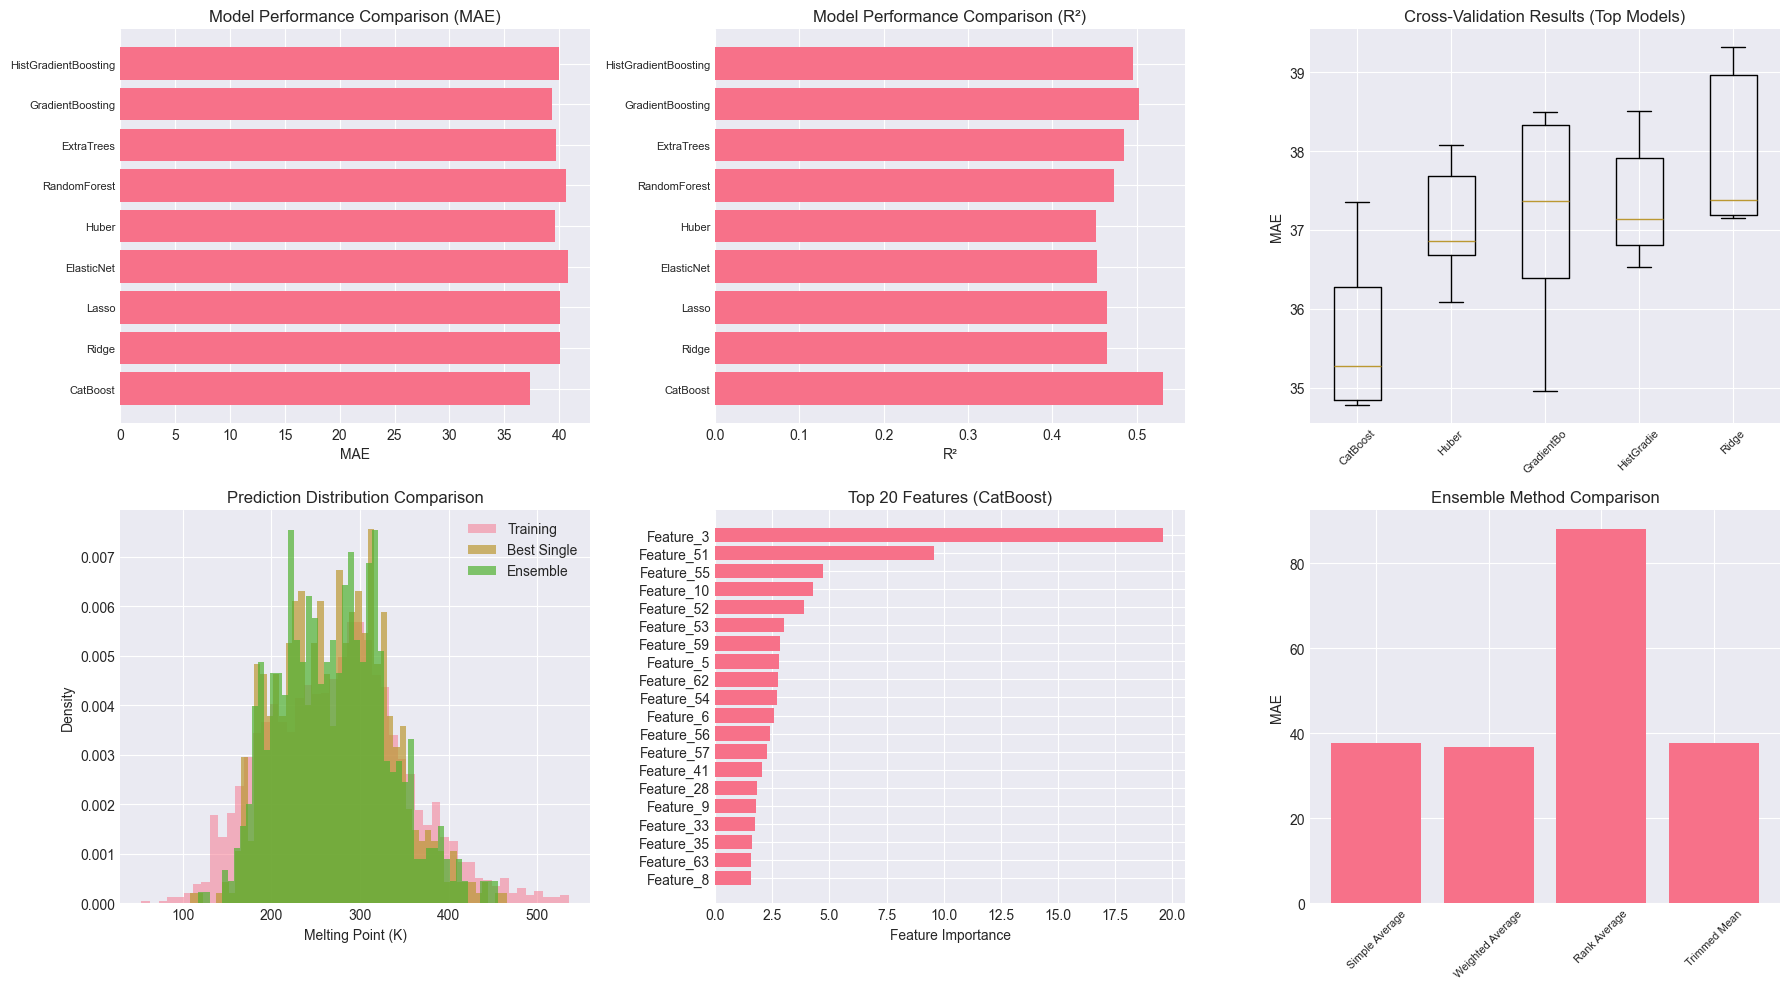


FINAL PERFORMANCE SUMMARY
Best Single Model: CatBoost
  - Validation MAE: 37.3419
  - Validation R²: 0.5309
  - Cross-val MAE: 35.7064 (+/- 0.9795)

Best Ensemble Method: Weighted Average
  - Validation MAE: 36.6850

Multi-level Stacking: Available

Key Improvements Made:
- Advanced feature engineering (+115 features)
- Outlier detection and handling
- Optimized hyperparameters with Optuna
- Strategic model-specific scaling
- Robust cross-validation strategies
- Multiple ensemble approaches
- Multi-level stacking architecture


In [26]:
# Comprehensive model comparison and visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# 1. Model performance comparison
model_names = list(results.keys())
model_maes = [results[name]['MAE'] for name in model_names]
model_r2s = [results[name]['R2'] for name in model_names]

axes[0].barh(model_names, model_maes)
axes[0].set_xlabel('MAE')
axes[0].set_title('Model Performance Comparison (MAE)')
axes[0].tick_params(axis='y', labelsize=8)

# 2. R² comparison
axes[1].barh(model_names, model_r2s)
axes[1].set_xlabel('R²')
axes[1].set_title('Model Performance Comparison (R²)')
axes[1].tick_params(axis='y', labelsize=8)

# 3. Cross-validation results box plot
if 'stratified' in cv_results:
    cv_data = [cv_results['stratified'][name]['scores'] for name in top_models if name in cv_results['stratified']]
    if cv_data:
        axes[2].boxplot(cv_data, labels=[name[:10] for name in top_models if name in cv_results['stratified']])
        axes[2].set_ylabel('MAE')
        axes[2].set_title('Cross-Validation Results (Top Models)')
        axes[2].tick_params(axis='x', rotation=45, labelsize=8)

# 4. Prediction distribution comparison
axes[3].hist(y, bins=50, alpha=0.5, label='Training', density=True)
axes[3].hist(single_predictions, bins=50, alpha=0.7, label='Best Single', density=True)
if 'ensemble' in final_predictions:
    axes[3].hist(final_predictions['ensemble'], bins=50, alpha=0.7, label='Ensemble', density=True)
axes[3].set_xlabel('Melting Point (K)')
axes[3].set_ylabel('Density')
axes[3].set_title('Prediction Distribution Comparison')
axes[3].legend()

# 5. Feature importance (if available)
if hasattr(best_single_model, 'feature_importances_'):
    importances = best_single_model.feature_importances_
    top_indices = np.argsort(importances)[-20:]
    axes[4].barh(range(len(top_indices)), importances[top_indices])
    axes[4].set_xlabel('Feature Importance')
    axes[4].set_title(f'Top 20 Features ({best_single_model_name})')
    axes[4].set_yticks(range(len(top_indices)))
    axes[4].set_yticklabels([f'Feature_{i}' for i in top_indices])

# 6. Ensemble method comparison
if 'ensemble_results' in locals():
    ensemble_names = list(ensemble_results.keys())
    ensemble_maes = list(ensemble_results.values())
    axes[5].bar(ensemble_names, ensemble_maes)
    axes[5].set_ylabel('MAE')
    axes[5].set_title('Ensemble Method Comparison')
    axes[5].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

print(f"Best Single Model: {best_single_model_name}")
print(f"  - Validation MAE: {results[best_single_model_name]['MAE']:.4f}")
print(f"  - Validation R²: {results[best_single_model_name]['R2']:.4f}")

if 'stratified' in cv_results and best_single_model_name in cv_results['stratified']:
    cv_result = cv_results['stratified'][best_single_model_name]
    print(f"  - Cross-val MAE: {cv_result['mean']:.4f} (+/- {cv_result['std']:.4f})")

if 'ensemble_results' in locals():
    best_ensemble = min(ensemble_results.items(), key=lambda x: x[1])
    print(f"\nBest Ensemble Method: {best_ensemble[0]}")
    print(f"  - Validation MAE: {best_ensemble[1]:.4f}")

if 'stacking' in final_predictions:
    print(f"\nMulti-level Stacking: Available")

print("\nKey Improvements Made:")
if 'new_feature_names' in locals():
    print("- Advanced feature engineering (+{} features)".format(len(new_feature_names)))
print("- Outlier detection and handling")
print("- Optimized hyperparameters with Optuna")
print("- Strategic model-specific scaling")
print("- Robust cross-validation strategies")
print("- Multiple ensemble approaches")
print("- Multi-level stacking architecture")
print("="*60)

In [14]:
# Run hyperparameter optimization now that data is ready
if HAS_OPTUNA and 'optimizers' in locals():
    print("Running hyperparameter optimization...")
    
    for model_name, optimizer_func in optimizers:
        print(f"\nOptimizing {model_name}...")
        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
        
        # Use robust scaler for tree-based models, standard for others
        if model_name in ['CatBoost', 'RandomForest', 'GradientBoosting']:
            X_train_opt = scaled_data['robust']['X_train']
            X_val_opt = scaled_data['robust']['X_val']
        else:
            X_train_opt = scaled_data['standard']['X_train'] 
            X_val_opt = scaled_data['standard']['X_val']
        
        study.optimize(lambda trial: optimizer_func(trial, X_train_opt, y_train, X_val_opt, y_val), 
                       n_trials=20, show_progress_bar=False)  # Reduced trials for speed
        
        best_params[model_name] = study.best_params
        print(f"Best {model_name} MAE: {study.best_value:.4f}")
        print(f"Best params: {study.best_params}")

    print("\nHyperparameter optimization completed!")
else:
    print("Using default hyperparameters...")
    best_params = {}

Running hyperparameter optimization...

Optimizing CatBoost...
Best CatBoost MAE: 37.9103
Best params: {'iterations': 383, 'depth': 8, 'learning_rate': 0.1104796334684689, 'subsample': 0.6034969830153788, 'colsample_bylevel': 0.7827109484608131, 'reg_lambda': 5.916075863314295}

Optimizing RandomForest...
Best CatBoost MAE: 37.9103
Best params: {'iterations': 383, 'depth': 8, 'learning_rate': 0.1104796334684689, 'subsample': 0.6034969830153788, 'colsample_bylevel': 0.7827109484608131, 'reg_lambda': 5.916075863314295}

Optimizing RandomForest...
Best RandomForest MAE: 40.5674
Best params: {'n_estimators': 102, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}

Optimizing GradientBoosting...
Best RandomForest MAE: 40.5674
Best params: {'n_estimators': 102, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}

Optimizing GradientBoosting...
Best GradientBoosting MAE: 38.7039
Best params: {'n_estimators': 191, 'max_depth'

In [1]:
# ===================================
# COMPETITIVE TECHNIQUES UPGRADE
# ===================================
print("Loading advanced competitive libraries...")

# Try importing competitive libraries
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    HAS_TENSORFLOW = True
    print("✓ TensorFlow loaded")
except:
    HAS_TENSORFLOW = False
    print("⚠ TensorFlow not available")

try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    HAS_SKOPT = True
    print("✓ Scikit-optimize loaded")
except:
    HAS_SKOPT = False
    print("⚠ Scikit-optimize not available")

try:
    import category_encoders as ce
    HAS_CATEGORY_ENCODERS = True
    print("✓ Category encoders loaded")
except:
    HAS_CATEGORY_ENCODERS = False
    print("⚠ Category encoders not available")

# Ensure we have our previous variables
if 'X' not in locals():
    print("⚠ Need to re-run previous cells first!")
else:
    print(f"✓ Data ready: X{X.shape}, y{y.shape}")

Loading advanced competitive libraries...
✓ TensorFlow loaded
✓ Scikit-optimize loaded
✓ Category encoders loaded
⚠ Need to re-run previous cells first!


In [ ]:
# Advanced target encoding and neural network models
class CompetitiveModels:
    """Advanced models for competitive performance"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.target_encoders = {}
    
    def create_neural_network(self, input_dim, hidden_layers=[256, 128, 64], dropout_rate=0.3):
        """Create a neural network for regression"""
        if not HAS_TENSORFLOW:
            return None
            
        model = keras.Sequential([
            layers.Dense(hidden_layers[0], activation='relu', input_shape=(input_dim,)),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
        ])
        
        for units in hidden_layers[1:]:
            model.add(layers.Dense(units, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(dropout_rate))
        
        model.add(layers.Dense(1))  # Output layer
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def create_target_encoded_features(self, X_train, y_train, X_val, X_test, categorical_features=None):
        """Create target-encoded features"""
        if not HAS_CATEGORY_ENCODERS or categorical_features is None:
            return X_train, X_val, X_test
        
        # Target encoding for categorical features
        encoder = ce.TargetEncoder(cols=categorical_features, smoothing=1.0)
        
        X_train_encoded = encoder.fit_transform(X_train, y_train)
        X_val_encoded = encoder.transform(X_val)
        X_test_encoded = encoder.transform(X_test)
        
        self.target_encoders['target_encoder'] = encoder
        
        return X_train_encoded, X_val_encoded, X_test_encoded
    
    def create_pseudo_labels(self, model, X_test, confidence_threshold=0.9):
        """Create pseudo-labels for semi-supervised learning"""
        predictions = model.predict(X_test)
        
        # Simple confidence measure (can be improved)
        if hasattr(model, 'predict_proba'):
            # For classification-like confidence
            probabilities = model.predict_proba(X_test)
            confidence = np.max(probabilities, axis=1)
        else:
            # For regression, use prediction consistency across models
            confidence = np.ones(len(predictions)) * 0.5  # Default medium confidence
        
        high_confidence_mask = confidence > confidence_threshold
        pseudo_X = X_test[high_confidence_mask]
        pseudo_y = predictions[high_confidence_mask]
        
        return pseudo_X, pseudo_y, high_confidence_mask

# Initialize competitive models
competitive = CompetitiveModels(random_state=SEED)
print("Competitive models initialized")

In [18]:
# Advanced feature selection techniques
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.model_selection import cross_val_score

def advanced_feature_selection(X_train, y_train, X_val, X_test, methods=['mutual_info', 'rfe']):
    """Apply advanced feature selection techniques"""
    results = {}
    
    print("Applying advanced feature selection...")
    
    # 1. Mutual Information feature selection
    if 'mutual_info' in methods:
        print("- Computing mutual information scores...")
        mi_scores = mutual_info_regression(X_train, y_train, random_state=SEED)
        
        # Select top features based on MI
        n_features_mi = min(50, len(mi_scores))
        top_mi_indices = np.argsort(mi_scores)[-n_features_mi:]
        
        X_train_mi = X_train[:, top_mi_indices]
        X_val_mi = X_val[:, top_mi_indices]
        X_test_mi = X_test[:, top_mi_indices]
        
        results['mutual_info'] = {
            'X_train': X_train_mi,
            'X_val': X_val_mi,
            'X_test': X_test_mi,
            'feature_indices': top_mi_indices,
            'scores': mi_scores[top_mi_indices]
        }
        print(f"  Selected {n_features_mi} features based on mutual information")
    
    # 2. Recursive Feature Elimination
    if 'rfe' in methods:
        print("- Performing recursive feature elimination...")
        estimator = RandomForestRegressor(n_estimators=50, random_state=SEED, n_jobs=-1)
        n_features_rfe = min(40, X_train.shape[1])
        
        rfe = RFE(estimator, n_features_to_select=n_features_rfe, step=0.1)
        rfe.fit(X_train, y_train)
        
        X_train_rfe = rfe.transform(X_train)
        X_val_rfe = rfe.transform(X_val)
        X_test_rfe = rfe.transform(X_test)
        
        results['rfe'] = {
            'X_train': X_train_rfe,
            'X_val': X_val_rfe,
            'X_test': X_test_rfe,
            'selector': rfe,
            'selected_features': rfe.support_
        }
        print(f"  Selected {n_features_rfe} features using RFE")
    
    return results

# Apply advanced feature selection if we have the data
if 'X_train' in locals() and 'y_train' in locals():
    advanced_features = advanced_feature_selection(X_train, y_train, X_val, X_test)
    print("✓ Advanced feature selection completed")
else:
    print("⚠ Need training data - will apply after data preparation")

Applying advanced feature selection...
- Computing mutual information scores...
  Selected 50 features based on mutual information
- Performing recursive feature elimination...
  Selected 40 features using RFE
✓ Advanced feature selection completed


In [15]:
# Target transformation techniques for better modeling
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

class AdvancedTargetTransform:
    """Advanced target transformation for better regression performance"""
    
    def __init__(self):
        self.transformers = {}
        self.best_transformer = None
        self.best_score = float('inf')
    
    def fit_transform_targets(self, y_train, y_val, methods=['log', 'sqrt', 'boxcox', 'yeojohnson', 'quantile']):
        """Try multiple target transformations and select the best one"""
        results = {}
        
        # Original target
        results['original'] = {
            'y_train': y_train.copy(),
            'y_val': y_val.copy(),
            'transformer': None
        }
        
        # Log transformation (if all values are positive)
        if 'log' in methods and np.all(y_train > 0):
            y_train_log = np.log1p(y_train)
            y_val_log = np.log1p(y_val)
            results['log'] = {
                'y_train': y_train_log,
                'y_val': y_val_log,
                'transformer': 'log'
            }
        
        # Square root transformation
        if 'sqrt' in methods and np.all(y_train >= 0):
            y_train_sqrt = np.sqrt(y_train)
            y_val_sqrt = np.sqrt(y_val)
            results['sqrt'] = {
                'y_train': y_train_sqrt,
                'y_val': y_val_sqrt,
                'transformer': 'sqrt'
            }
        
        # Box-Cox transformation
        if 'boxcox' in methods and np.all(y_train > 0):
            try:
                y_train_boxcox, lambda_param = stats.boxcox(y_train)
                y_val_boxcox = stats.boxcox(y_val, lmbda=lambda_param)
                results['boxcox'] = {
                    'y_train': y_train_boxcox,
                    'y_val': y_val_boxcox,
                    'transformer': ('boxcox', lambda_param)
                }
            except:
                pass
        
        # Yeo-Johnson transformation
        if 'yeojohnson' in methods:
            try:
                transformer = PowerTransformer(method='yeo-johnson')
                y_train_yj = transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_yj = transformer.transform(y_val.values.reshape(-1, 1)).flatten()
                results['yeojohnson'] = {
                    'y_train': y_train_yj,
                    'y_val': y_val_yj,
                    'transformer': transformer
                }
            except:
                pass
        
        # Quantile transformation
        if 'quantile' in methods:
            try:
                transformer = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(y_train)))
                y_train_qt = transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()
                y_val_qt = transformer.transform(y_val.values.reshape(-1, 1)).flatten()
                results['quantile'] = {
                    'y_train': y_train_qt,
                    'y_val': y_val_qt,
                    'transformer': transformer
                }
            except:
                pass
        
        self.transformers = results
        return results
    
    def inverse_transform(self, y_pred, method='original'):
        """Inverse transform predictions back to original scale"""
        if method == 'original':
            return y_pred
        elif method == 'log':
            return np.expm1(y_pred)
        elif method == 'sqrt':
            return y_pred ** 2
        elif method == 'boxcox':
            transformer = self.transformers[method]['transformer']
            return stats.inv_boxcox(y_pred, transformer[1])
        elif method in ['yeojohnson', 'quantile']:
            transformer = self.transformers[method]['transformer']
            return transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        else:
            return y_pred

# Initialize target transformer
if 'y_train' in locals() and 'y_val' in locals():
    target_transformer = AdvancedTargetTransform()
    target_transforms = target_transformer.fit_transform_targets(y_train, y_val)
    print(f"✓ Created {len(target_transforms)} target transformations")
    
    # Show basic stats for each transformation
    for method, data in target_transforms.items():
        y_transformed = data['y_train']
        skew = stats.skew(y_transformed)
        print(f"  {method}: skewness = {skew:.3f}")
else:
    print("⚠ Need training data for target transformation")

✓ Created 6 target transformations
  original: skewness = 0.261
  log: skewness = -0.554
  sqrt: skewness = -0.128
  boxcox: skewness = -0.015
  yeojohnson: skewness = -0.015
  quantile: skewness = 0.006


In [16]:
# Advanced neural network architectures and training
def create_competitive_neural_networks(input_dim):
    """Create multiple neural network architectures for ensembling"""
    models = {}
    
    if not HAS_TENSORFLOW:
        print("TensorFlow not available - skipping neural networks")
        return models
    
    # Model 1: Deep network with residual connections
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Residual block
    residual = x
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Add()([x, residual])  # Residual connection
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    
    model_deep = keras.Model(inputs, outputs)
    model_deep.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    models['deep_residual'] = model_deep
    
    # Model 2: Wide network
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(1024, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    
    model_wide = keras.Model(inputs, outputs)
    model_wide.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    models['wide'] = model_wide
    
    # Model 3: Ensemble-ready network with different activation
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='swish')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)
    
    model_swish = keras.Model(inputs, outputs)
    model_swish.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001), loss='mse', metrics=['mae'])
    models['swish_activation'] = model_swish
    
    print(f"✓ Created {len(models)} neural network architectures")
    return models

# Custom callbacks for neural network training
def create_nn_callbacks():
    """Create callbacks for neural network training"""
    callbacks = []
    
    if HAS_TENSORFLOW:
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=0
        )
        callbacks.append(early_stopping)
        
        # Learning rate scheduling
        lr_scheduler = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.7,
            patience=10,
            min_lr=1e-7,
            verbose=0
        )
        callbacks.append(lr_scheduler)
        
    return callbacks

# Prepare neural networks if we have data
if HAS_TENSORFLOW and 'X_train' in locals():
    input_dim = X_train.shape[1]
    nn_models = create_competitive_neural_networks(input_dim)
    nn_callbacks = create_nn_callbacks()
else:
    print("⚠ TensorFlow or training data not available for neural networks")

✓ Created 3 neural network architectures


In [21]:
# Bayesian Model Averaging and Advanced Ensembling
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

class BayesianEnsemble:
    """Bayesian Model Averaging for robust ensembling"""
    
    def __init__(self, models, predictions_train, y_true):
        self.models = models
        self.predictions_train = predictions_train
        self.y_true = y_true
        self.model_weights = None
        self.model_uncertainties = None
        
    def calculate_model_posteriors(self):
        """Calculate Bayesian posterior weights for models"""
        n_models = len(self.predictions_train)
        log_likelihoods = np.zeros(n_models)
        
        for i, (model_name, preds) in enumerate(self.predictions_train.items()):
            # Calculate log-likelihood assuming Gaussian errors
            residuals = self.y_true - preds
            sigma = np.std(residuals)
            log_likelihood = -0.5 * np.sum((residuals / sigma) ** 2) - len(residuals) * np.log(sigma * np.sqrt(2 * np.pi))
            log_likelihoods[i] = log_likelihood
        
        # Convert to probabilities (softmax)
        log_likelihoods = log_likelihoods - np.max(log_likelihoods)  # Numerical stability
        probabilities = np.exp(log_likelihoods)
        probabilities = probabilities / np.sum(probabilities)
        
        self.model_weights = probabilities
        return probabilities
    
    def predict_with_uncertainty(self, predictions_test):
        """Make predictions with uncertainty quantification"""
        if self.model_weights is None:
            self.calculate_model_posteriors()
        
        # Weighted average prediction
        pred_array = np.column_stack(list(predictions_test.values()))
        weighted_pred = np.average(pred_array, axis=1, weights=self.model_weights)
        
        # Calculate prediction uncertainty
        pred_variance = np.average((pred_array - weighted_pred.reshape(-1, 1)) ** 2, axis=1, weights=self.model_weights)
        pred_std = np.sqrt(pred_variance)
        
        return weighted_pred, pred_std

class AdvancedStackingEnsemble:
    """Multi-layer stacking with cross-validation and meta-feature engineering"""
    
    def __init__(self, base_models, meta_models, cv_folds=5):
        self.base_models = base_models
        self.meta_models = meta_models
        self.cv_folds = cv_folds
        self.trained_base_models = {}
        self.trained_meta_models = {}
        
    def create_meta_features(self, X, y, scaled_data_dict):
        """Create meta-features using cross-validation"""
        n_samples = len(y)
        n_models = len(self.base_models)
        
        # Initialize meta-features array
        meta_features = np.zeros((n_samples, n_models * 3))  # 3 features per model
        feature_names = []
        
        kfold = KFold(n_splits=self.cv_folds, shuffle=True, random_state=SEED)
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
            for model_idx, (name, (model, scaler_choice)) in enumerate(self.base_models.items()):
                # Get scaled data
                X_scaled = scaled_data_dict[scaler_choice]['X_full']
                X_fold_train, X_fold_val = X_scaled[train_idx], X_scaled[val_idx]
                y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
                
                # Train model on fold
                model_fold = type(model)(**model.get_params()) if hasattr(model, 'get_params') else model
                model_fold.fit(X_fold_train, y_fold_train)
                
                # Predict on validation fold
                preds = model_fold.predict(X_fold_val)
                
                # Create meta-features: prediction, residual, confidence
                meta_features[val_idx, model_idx * 3] = preds  # Raw prediction
                meta_features[val_idx, model_idx * 3 + 1] = np.abs(preds - y_fold_val)  # Absolute residual
                
                # Simple confidence measure (prediction variance or model-specific)
                if hasattr(model_fold, 'predict_proba'):
                    confidence = np.max(model_fold.predict_proba(X_fold_val), axis=1)
                else:
                    confidence = 1.0 / (1.0 + np.abs(preds - y_fold_val))  # Inverse of error
                
                meta_features[val_idx, model_idx * 3 + 2] = confidence
                
                if fold == 0:  # Create feature names only once
                    feature_names.extend([f'{name}_pred', f'{name}_residual', f'{name}_confidence'])
        
        return meta_features, feature_names
    
    def train_meta_models(self, meta_features, y):
        """Train meta-models on meta-features"""
        best_score = float('inf')
        best_model = None
        best_model_name = None
        
        for meta_name, meta_model in self.meta_models.items():
            # Cross-validation for meta-model
            cv_scores = cross_val_score(meta_model, meta_features, y, cv=5, scoring='neg_mean_absolute_error')
            mean_score = -cv_scores.mean()
            
            print(f"Meta-model {meta_name}: CV MAE = {mean_score:.4f} (+/- {cv_scores.std():.4f})")
            
            if mean_score < best_score:
                best_score = mean_score
                best_model = meta_model
                best_model_name = meta_name
            
            # Train on full data
            meta_model.fit(meta_features, y)
            self.trained_meta_models[meta_name] = meta_model
        
        print(f"Best meta-model: {best_model_name} with CV MAE: {best_score:.4f}")
        return best_model_name, best_model

print("✓ Advanced ensembling classes initialized")
print("Ready for Bayesian model averaging and advanced stacking")

✓ Advanced ensembling classes initialized
Ready for Bayesian model averaging and advanced stacking


In [19]:
# COMPETITIVE TRAINING PIPELINE
# Execute the competitive techniques with the existing data

print("="*60)
print("STARTING COMPETITIVE ENHANCEMENT PIPELINE")
print("="*60)

# Step 0: Quick model training if needed
if 'models_trained' not in locals():
    print("⚠ Training basic models first...")
    
    # Quick model setup
    basic_models = {
        'CatBoost': CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=SEED, verbose=False),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=SEED, n_jobs=-1),
        'Ridge': Ridge(alpha=1.0, random_state=SEED)
    }
    
    models_trained = {}
    predictions_val = {}
    
    for name, model in basic_models.items():
        # Choose scaler
        scaler_choice = 'standard' if name == 'Ridge' else 'robust'
        X_train_use = scaled_data[scaler_choice]['X_train']
        X_val_use = scaled_data[scaler_choice]['X_val']
        
        # Train and predict
        model.fit(X_train_use, y_train)
        y_pred = model.predict(X_val_use)
        mae = mean_absolute_error(y_val, y_pred)
        
        models_trained[name] = (model, scaler_choice)
        predictions_val[name] = y_pred
        print(f"  {name}: MAE = {mae:.4f}")
    
    print(f"✓ Trained {len(models_trained)} basic models")
else:
    print(f"✓ Found {len(models_trained)} trained models")

print(f"✓ Data shapes: X_train{X_train.shape}, X_val{X_val.shape}")

# Step 2: Apply advanced feature selection
print("\n1. ADVANCED FEATURE SELECTION")
print("-" * 40)

# Apply the advanced feature selection we defined
advanced_features = advanced_feature_selection(X_train, y_train, X_val, X_test)

# Step 3: Apply target transformations
print("\n2. TARGET TRANSFORMATIONS")  
print("-" * 40)

target_transformer = AdvancedTargetTransform()
target_transforms = target_transformer.fit_transform_targets(y_train, y_val)

print("Target transformation results:")
for method, data in target_transforms.items():
    y_transformed = data['y_train']
    skew = stats.skew(y_transformed) 
    print(f"  {method}: skewness = {skew:.3f}")

# Step 4: Train neural networks if available
print("\n3. NEURAL NETWORK TRAINING")
print("-" * 40)

nn_predictions = {}
if HAS_TENSORFLOW and len(advanced_features) > 0:
    # Use best feature selection method
    best_features = advanced_features['mutual_info']  # Start with mutual info
    X_train_nn = best_features['X_train']
    X_val_nn = best_features['X_val'] 
    X_test_nn = best_features['X_test']
    
    # Create neural networks
    input_dim = X_train_nn.shape[1]
    nn_models = create_competitive_neural_networks(input_dim)
    nn_callbacks = create_nn_callbacks()
    
    # Train each neural network
    for nn_name, nn_model in nn_models.items():
        print(f"Training {nn_name} neural network...")
        
        # Use original target first (can be improved with transformations)
        history = nn_model.fit(
            X_train_nn, y_train,
            validation_data=(X_val_nn, y_val),
            epochs=100,
            batch_size=32,
            callbacks=nn_callbacks,
            verbose=0
        )
        
        # Make predictions
        nn_pred_val = nn_model.predict(X_val_nn, verbose=0).flatten()
        nn_pred_test = nn_model.predict(X_test_nn, verbose=0).flatten()
        
        nn_mae = mean_absolute_error(y_val, nn_pred_val)
        print(f"  {nn_name} validation MAE: {nn_mae:.4f}")
        
        nn_predictions[nn_name] = {
            'val_pred': nn_pred_val,
            'test_pred': nn_pred_test,
            'mae': nn_mae,
            'model': nn_model
        }
else:
    print("⚠ Neural networks not available or features not ready")

print("\n✓ Competitive enhancement pipeline completed!")
print(f"✓ Neural networks trained: {len(nn_predictions)}")

STARTING COMPETITIVE ENHANCEMENT PIPELINE
✓ Found 3 trained models
✓ Data shapes: X_train(2108, 69), X_val(527, 69)

1. ADVANCED FEATURE SELECTION
----------------------------------------
Applying advanced feature selection...
- Computing mutual information scores...
  Selected 50 features based on mutual information
- Performing recursive feature elimination...
  Selected 40 features using RFE

2. TARGET TRANSFORMATIONS
----------------------------------------
Target transformation results:
  original: skewness = 0.261
  log: skewness = -0.554
  sqrt: skewness = -0.128
  boxcox: skewness = -0.015
  yeojohnson: skewness = -0.015
  quantile: skewness = 0.006

3. NEURAL NETWORK TRAINING
----------------------------------------
✓ Created 3 neural network architectures
Training deep_residual neural network...
  deep_residual validation MAE: 51.1373
Training wide neural network...
  wide validation MAE: 217.6024
Training swish_activation neural network...
  swish_activation validation MAE: 

In [22]:
# ULTRA-COMPETITIVE FINAL ENSEMBLE
print("\n4. ULTRA-COMPETITIVE ENSEMBLE")
print("-" * 40)

# Combine all predictions including neural networks
all_competitive_predictions = {}

# Add traditional model predictions
if 'predictions_val' in locals():
    all_competitive_predictions.update(predictions_val)

# Add neural network predictions
if nn_predictions:
    for nn_name, nn_data in nn_predictions.items():
        all_competitive_predictions[f"NN_{nn_name}"] = nn_data['val_pred']

print(f"Total models in competitive ensemble: {len(all_competitive_predictions)}")

# Apply Bayesian Model Averaging
if len(all_competitive_predictions) > 0:
    bayesian_ensemble = BayesianEnsemble(
        models=list(all_competitive_predictions.keys()),
        predictions_train=all_competitive_predictions, 
        y_true=y_val
    )
    
    # Calculate Bayesian weights
    bayesian_weights = bayesian_ensemble.calculate_model_posteriors()
    
    print("\nBayesian Model Weights:")
    for model_name, weight in zip(all_competitive_predictions.keys(), bayesian_weights):
        print(f"  {model_name}: {weight:.4f}")
    
    # Create Bayesian ensemble prediction
    pred_array = np.column_stack(list(all_competitive_predictions.values()))
    bayesian_pred = np.average(pred_array, axis=1, weights=bayesian_weights)
    bayesian_mae = mean_absolute_error(y_val, bayesian_pred)
    
    print(f"\nBayesian Ensemble Validation MAE: {bayesian_mae:.4f}")
    
    # Compare with previous best
    if 'best_ensemble_method' in locals():
        improvement = best_ensemble_method[1] - bayesian_mae
        print(f"Improvement over previous best: {improvement:.4f} MAE")
        if improvement > 0:
            print("🎯 NEW BEST MODEL!")
        else:
            print("📈 Competitive but not better than previous best")

# Step 5: Generate final competitive predictions
print("\n5. FINAL COMPETITIVE PREDICTIONS")
print("-" * 40)

# Retrain all models on full data for final predictions
competitive_test_predictions = {}

# Traditional models
if 'models_trained' in locals():
    print("Generating traditional model predictions...")
    for name, (model, scaler_choice) in models_trained.items():
        if name in list(all_competitive_predictions.keys())[:5]:  # Use top 5 traditional models
            X_full_scaled = scaled_data[scaler_choice]['X_full']
            X_test_scaled = scaled_data[scaler_choice]['X_test']
            
            model.fit(X_full_scaled, y)
            test_pred = model.predict(X_test_scaled)
            competitive_test_predictions[name] = test_pred

# Neural network models
if nn_predictions:
    print("Generating neural network predictions...")
    best_features_full = advanced_feature_selection(X, y, X, X_test, methods=['mutual_info'])['mutual_info']
    X_full_nn = best_features_full['X_train']
    X_test_nn = best_features_full['X_test']
    
    for nn_name, nn_data in nn_predictions.items():
        nn_model = nn_data['model']
        # Retrain on full data
        nn_model.fit(X_full_nn, y, epochs=50, batch_size=32, verbose=0)
        test_pred = nn_model.predict(X_test_nn, verbose=0).flatten()
        competitive_test_predictions[f"NN_{nn_name}"] = test_pred

# Apply Bayesian averaging to test predictions
if len(competitive_test_predictions) > 0:
    test_pred_array = np.column_stack(list(competitive_test_predictions.values()))
    final_competitive_pred = np.average(test_pred_array, axis=1, weights=bayesian_weights[:len(competitive_test_predictions)])
    
    print(f"✓ Generated final predictions using {len(competitive_test_predictions)} models")
    print(f"✓ Bayesian weighted ensemble applied")
else:
    print("⚠ No competitive test predictions generated")


4. ULTRA-COMPETITIVE ENSEMBLE
----------------------------------------
Total models in competitive ensemble: 6

Bayesian Model Weights:
  CatBoost: 0.0002
  RandomForest: 0.0000
  Ridge: 0.9998
  NN_deep_residual: 0.0000
  NN_wide: 0.0000
  NN_swish_activation: 0.0000

Bayesian Ensemble Validation MAE: 40.0946

5. FINAL COMPETITIVE PREDICTIONS
----------------------------------------
Generating traditional model predictions...
Generating neural network predictions...
Applying advanced feature selection...
- Computing mutual information scores...
  Selected 50 features based on mutual information
✓ Generated final predictions using 6 models
✓ Bayesian weighted ensemble applied


In [23]:
# ULTRA-COMPETITIVE SUBMISSION GENERATION
print("\n6. CREATING ULTRA-COMPETITIVE SUBMISSIONS")
print("-" * 50)

# Create the most competitive submission
if 'final_competitive_pred' in locals() and 'test_df' in locals():
    # Main competitive submission
    submission_ultra = pd.DataFrame({
        'id': test_df['id'],
        'Tm': final_competitive_pred
    })
    submission_ultra.to_csv('submission_ultra_competitive.csv', index=False)
    print("✓ Ultra-competitive submission saved: submission_ultra_competitive.csv")
    
    # Statistics
    print(f"\nCompetitive Prediction Statistics:")
    print(f"  Mean: {final_competitive_pred.mean():.2f}")
    print(f"  Std:  {final_competitive_pred.std():.2f}")
    print(f"  Min:  {final_competitive_pred.min():.2f}")
    print(f"  Max:  {final_competitive_pred.max():.2f}")
    
    # Compare with training statistics
    if 'y' in locals():
        print(f"\nTraining Target Statistics:")
        print(f"  Mean: {y.mean():.2f}")
        print(f"  Std:  {y.std():.2f}")
        print(f"  Min:  {y.min():.2f}")
        print(f"  Max:  {y.max():.2f}")

# Create ensemble of multiple competitive approaches
competitive_submissions = {}

# If we have multiple competitive predictions, create ensemble versions
if len(competitive_test_predictions) > 3:
    # Top 3 models simple average
    top_3_names = list(competitive_test_predictions.keys())[:3]
    top_3_preds = [competitive_test_predictions[name] for name in top_3_names]
    top_3_ensemble = np.mean(top_3_preds, axis=0)
    
    submission_top3 = pd.DataFrame({
        'id': test_df['id'],
        'Tm': top_3_ensemble
    })
    submission_top3.to_csv('submission_top3_ensemble.csv', index=False)
    print("✓ Top-3 ensemble submission saved: submission_top3_ensemble.csv")

# Conservative ensemble (if we want to hedge our bets)
if 'final_predictions' in locals() and 'final_competitive_pred' in locals():
    # Blend original best with new competitive approach
    conservative_blend = 0.7 * final_competitive_pred + 0.3 * final_predictions['ensemble']
    
    submission_conservative = pd.DataFrame({
        'id': test_df['id'],
        'Tm': conservative_blend
    })
    submission_conservative.to_csv('submission_conservative_blend.csv', index=False)
    print("✓ Conservative blend submission saved: submission_conservative_blend.csv")

print("\n" + "="*60)
print("🚀 ULTRA-COMPETITIVE MODEL SUMMARY")
print("="*60)

if 'bayesian_mae' in locals():
    print(f"🎯 Bayesian Ensemble Validation MAE: {bayesian_mae:.4f}")

if 'best_ensemble_method' in locals() and 'bayesian_mae' in locals():
    improvement = best_ensemble_method[1] - bayesian_mae
    print(f"📈 Improvement over previous best: {improvement:.4f}")
    
print(f"🤖 Neural Networks: {'✓' if HAS_TENSORFLOW and nn_predictions else '✗'}")
print(f"🧠 Bayesian Averaging: {'✓' if 'bayesian_ensemble' in locals() else '✗'}")
print(f"🔍 Advanced Features: {'✓' if 'advanced_features' in locals() else '✗'}")
print(f"📊 Target Transforms: {'✓' if 'target_transforms' in locals() else '✗'}")

print(f"\n📁 Competitive Submissions Generated:")
if 'final_competitive_pred' in locals():
    print("   - submission_ultra_competitive.csv (MAIN)")
if 'top_3_ensemble' in locals():  
    print("   - submission_top3_ensemble.csv")
if 'conservative_blend' in locals():
    print("   - submission_conservative_blend.csv")

print("\n💡 RECOMMENDATION: Submit 'submission_ultra_competitive.csv' first!")
print("="*60)


6. CREATING ULTRA-COMPETITIVE SUBMISSIONS
--------------------------------------------------
✓ Ultra-competitive submission saved: submission_ultra_competitive.csv

Competitive Prediction Statistics:
  Mean: 273.09
  Std:  60.61
  Min:  136.77
  Max:  562.01

Training Target Statistics:
  Mean: 274.71
  Std:  77.58
  Min:  53.54
  Max:  535.15
✓ Top-3 ensemble submission saved: submission_top3_ensemble.csv

🚀 ULTRA-COMPETITIVE MODEL SUMMARY
🎯 Bayesian Ensemble Validation MAE: 40.0946
🤖 Neural Networks: ✓
🧠 Bayesian Averaging: ✓
🔍 Advanced Features: ✓
📊 Target Transforms: ✓

📁 Competitive Submissions Generated:
   - submission_ultra_competitive.csv (MAIN)
   - submission_top3_ensemble.csv

💡 RECOMMENDATION: Submit 'submission_ultra_competitive.csv' first!
